In [1]:
import os

import numpy as np
import importlib
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation
from matplotlib.colors import to_rgba

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import gym_env
import utils
from utils import make_plots, record_trajectory, create_transition_matrix_mapping, get_transition_matrix
# from LinearRL import LinearRL

In [2]:
class LinearRL:
    def __init__(self, env_name, alpha=0.1, gamma=0.904, _lambda=1.0, epsilon=0.4, num_steps=25000):
        self.env = gym.make(env_name)
        self.start_loc = self.env.unwrapped.start_loc
        self.target_loc = self.env.unwrapped.target_loc
        self.maze = self.env.unwrapped.maze
        self.size = self.maze.size
        self.height, self.width = self.maze.shape
        self.target_locs = [self.target_loc]
        # self.mapping = self.create_transition_matrix_mapping()
        # self.T = self.get_transition_matrix(size=self.size, mapping=self.mapping)
        self.mapping = create_transition_matrix_mapping(self.maze)
        self.T, self.barriers = get_transition_matrix(self.env, self.size, self.mapping)
        

        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]
        # self.P = self.T[:, self.terminals]
        # Calculate reward
        self.r = np.full(len(self.T), -0.1)     # our reward at each non-terminal state to be -1
        self.r[self.terminals] = 1           # reward at terminal state is 0
        self.expr_t = np.exp(self.r[self.terminals] / _lambda)      # exp(r) = exp(-c) at terminal state
        self.expr_nt = np.exp(-0.1/_lambda)     # exp(r) = exp(-c) at non-terminal states

        # Params
        self.alpha = alpha
        self.gamma = self.expr_nt
        self._lambda = _lambda
        self.epsilon = epsilon
        self.num_steps = num_steps

        # Model
        # self.DR = np.eye(self.size)
        self.DR = self.get_DR()
        self.Z = np.full(self.size, 0.01)
        # self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)

        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)
    
    def create_transition_matrix_mapping(self):
        """
        Creates a mapping from maze state indices to transition matrix indices
        """
        n = len(self.maze)  # Size of the maze (N)

        mapping = {}
        matrix_idx = 0

        for i in range(n):
            for j in range(n):
                mapping[(i,j)] = matrix_idx
                matrix_idx += 1

        return mapping
    
    # TODO : Remove this and add to maze_env
    def get_transition_matrix(self, size, mapping):
        # TODO : Make this a part of maze_env
        barriers = []

        T = np.zeros(shape=(size, size))
        # loop through the maze
        for row in range(self.maze.shape[0]):
            for col in range(self.maze.shape[1]):            
                # if we hit a barrier
                if self.maze[row,col] == '1':
                    barriers.append(mapping[row, col])
                    continue

                idx_cur = mapping[row, col]

                # check if current state is terminal
                if self.maze[row,col] == 'G':
                    T[idx_cur, idx_cur] = 1
                    continue

                state = (row,col)
                successor_states = self.env.unwrapped.get_successor_states(state)
                for successor_state in successor_states:
                    idx_new = mapping[successor_state[0][0], successor_state[0][1]]
                    T[idx_cur, idx_new] = 1/len(successor_states)
        
        return T, barriers

    def get_DR(self):
        DR = np.full((self.size, self.size), 0.01)
        DR[:, self.barriers] = 0
        DR[self.barriers, :] = 0
        np.fill_diagonal(DR, 1)

        return DR

    
    def update_V(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)
    
    def importance_sampling(self, state, s_prob):
        successor_states = self.env.unwrapped.get_successor_states(state)
        p = 1/len(successor_states)
        w = p/s_prob
                
        return w

    def select_action(self, state, policy="softmax", beta=5, target_loc=None):
        # print("\n Action Selection")
        if policy == "random":
            # print(f"current state: {state}, z-value: {self.Z[self.mapping[(state[0], state[1])]]}")
            return self.env.unwrapped.random_action()
        
        elif policy == "softmax":
            # print(f"current state: {state}, z-value: {self.Z[self.mapping[(state[0], state[1])]]}")
            successor_states = self.env.unwrapped.get_successor_states(state)      # succesor_states = [(state, terminated), ...]
            action_probs = np.full(self.env.action_space.n, 0.0)

            v_sum = sum(
                        np.exp((np.log(self.Z[self.mapping[(s[0][0],s[0][1])]] + 1e-20)) / beta) for s in successor_states
                        )

            # if we don't have enough info, random action
            if v_sum == 0:
                return self.env.unwrapped.random_action() 

            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction
                
                action_probs[action] = np.exp((np.log(self.Z[self.mapping[(new_state[0], new_state[1])]] + 1e-20)) / beta ) / v_sum

                # print(f"action: {action} new state: {new_state}, Z: {self.Z[self.mapping[(new_state[0], new_state[1])]]}")

            # print(state, action_probs)
            action = np.random.choice(self.env.action_space.n, p=action_probs)
            s_prob = action_probs[action]

            return action, s_prob
            # return np.random.choice(self.env.action_space.n, p=action_probs), 
    
        elif policy == "egreedy":
            # action_probs = np.full(self.env.action_space.n, 0.0)
            # action_values = np.full(self.env.action_space.n, -np.inf)
            # actions = self.env.unwrapped.get_available_actions(state)

            # for action in actions:
            #         direction = self.env.unwrapped._action_to_direction[action]
            #         new_state = state + direction

            #         action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]] + 1e-20), 2)
                        
            # maxval = np.max(action_values)
            # bestA = np.where(action_values == maxval)[0]

            # action_probs[bestA] = (1-self.epsilon) / len(bestA)
            # action_probs[actions] = action_probs[actions] + self.epsilon/len(actions)

            # return np.random.choice(self.env.action_space.n, p=action_probs)

            if np.random.uniform(low=0, high=1) < self.epsilon:
                return self.env.unwrapped.random_action()
            else:
                action_values = np.full(self.env.action_space.n, -np.inf)
                for action in self.env.unwrapped.get_available_actions(state):
                    direction = self.env.unwrapped._action_to_direction[action]
                    new_state = state + direction

                    if self.maze[new_state[0], new_state[1]] == "1":
                        continue

                    action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

                return np.argmax(action_values)
            
        elif policy == "test":
            action_values = np.full(self.env.action_space.n, -np.inf)
            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction

                # Need this to make it work for now
                if np.array_equal(new_state, target_loc):
                    return action

                if self.maze[new_state[0], new_state[1]] == "1":
                    continue
                action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

            return np.nanargmax(action_values)

    def get_D_inv(self):
        # L = np.diag(np.exp(-self.r)) - self.T
        # D_inv = np.linalg.inv(L)

        # New way of doing it
        I = np.eye(self.size)
        D_inv = np.linalg.inv(I-self.gamma*self.T)

        return D_inv

    def learn(self, policy="random"):
        """
        Agent randomly explores the maze and and updates its DR as it goes
        """
        print(f"Decision Policy: {policy}")
        self.env.reset()

        # TODO : Convergence
        differences = [list() for i in range(self.size)]
        D_inv = self.get_D_inv()

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Current state
            state = self.env.unwrapped.agent_loc
            state_idx = self.mapping[(state[0], state[1])]

            # Choose action (random for now)
            # action = self.env.unwrapped.random_action()
            if policy == "softmax":
                action, s_prob = self.select_action(state, policy)
            else:
                action = self.select_action(state, policy)

            # Take action
            obs, _, done, _, _ = self.env.step(action)

            # Unpack observation to get new state
            next_state = obs["agent"]
            next_state_idx = self.mapping[(next_state[0], next_state[1])]

            # Importance sampling
            if policy == "softmax":
                w = self.importance_sampling(state, s_prob)
                w = 1 if np.isnan(w) or w == 0 else w
                # w = 1
            else:
                w = 1
            
            ## Update default representation
            # TDE = self.one_hot[state_idx][~self.terminals] + self.gamma * self.DR[next_state_idx][~self.terminals]
                
            ### THIS WORKS ###
            TDE =  self.one_hot[state_idx] + self.gamma * self.DR[next_state_idx]
            #################

            # self.DR[state_idx][~self.terminals] = (1 - self.alpha) * self.DR[state_idx][~self.terminals] + self.alpha * TDE * w
            self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * TDE * w

            # TODO : Convergence
            ### THIS WORKS ###
            differences[state_idx].append(np.mean(np.abs(self.DR[state_idx] - D_inv[state_idx])))
            #################

            # differences[state_idx].append(np.mean(np.abs(self.DR[state_idx][~self.terminals] - D_inv[state_idx][~self.terminals])))


            # print(f"Pre Update - state: {state}, Z: {self.Z[state_idx]}")

            ## Update Z-Values

            # self.Z[state_idx] = self.DR[state_idx][~self.terminals] @ self.P @ self.expr_t

            ### THIS WORKS ###
            self.Z = self.DR[:,~self.terminals] @ self.P @ self.expr_t
            #################
            # print(f"Iteration: {i}, State: {state}, Z-value: {self.Z[self.mapping[(state[0], state[1])]]}")
            
            # print(f"DR: {self.DR[state_idx][~self.terminals]}")
            # print(f"Post Update - state: {state}, Z: {self.Z[state_idx]}")

            # Update state
            if done:
                self.env.reset()
                continue
            state = next_state
            
        
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)

        return differences

In [3]:
def test_agent(agent, state=None):
    """
    Function to test the agent
    """
    traj = []

    agent.env.reset()
    if state is None:
        state = agent.start_loc

    # Set start and agent location
    agent.env.unwrapped.start_loc, agent.env.unwrapped.agent_loc = state, state
    print(f"Starting in state: {state}")
    steps = 0
    done = False
    while not done:
        action = agent.select_action(state, policy="test", target_loc=agent.target_loc)
        obs, _, done, _, _ = agent.env.step(action)
        next_state = obs["agent"]
        traj.append(next_state)
        print(f"Took action: {action} and arrived in state: {next_state}")

        steps += 1
        state = next_state
    print(f"Took {steps} steps")

    return traj

In [4]:
# Baseline agent
agent = LinearRL(env_name="simple-5x5", _lambda=1.0, alpha=0.01, num_steps=2)

# Detour agent
# agent = LinearRL(env_name="tolman-9x9-nb", _lambda=1.0, alpha=0.01, gamma=0.95, num_steps=800000)


In [5]:
agent.DR.shape

(25, 25)

In [6]:
agent.barriers

[6, 7, 11, 12, 18]

In [42]:
diffs = agent.learn()

Decision Policy: random


/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_8246/92952791.py:295: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [7]:
agent.V.reshape((agent.height, agent.width))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [8]:
D_inv = agent.get_D_inv()
agent.DR = D_inv
agent.update_V()
agent.V.reshape((agent.height, agent.width))

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_8324/4235362585.py:100: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


array([[-2.  , -1.9 , -1.64, -1.27, -1.07],
       [-1.9 ,  -inf,  -inf, -0.93, -0.75],
       [-1.64,  -inf,  -inf, -0.59, -0.18],
       [-1.27, -0.93, -0.59,  -inf,  0.55],
       [-1.07, -0.75, -0.18,  0.55,  1.  ]])

In [26]:
agent.maze

array([['S', '0', '0', '0', '0'],
       ['0', '1', '1', '0', '0'],
       ['0', '1', '1', '0', '0'],
       ['0', '0', '0', '1', '0'],
       ['0', '0', '0', '0', 'G']], dtype='<U21')

## Convergences

In [27]:
reverse_mapping = {value: key for key, value in agent.mapping.items()}

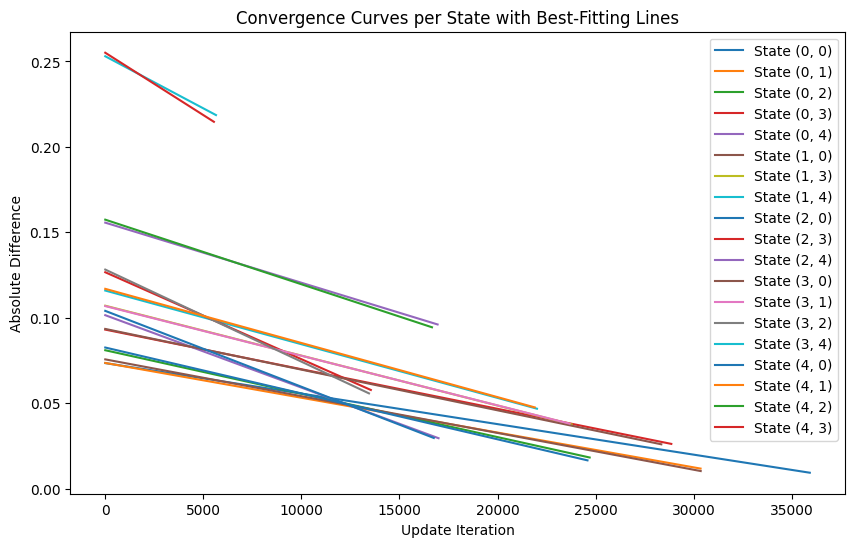

In [28]:
# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot convergence curves with best-fitting lines
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Convergence Curves per State with Best-Fitting Lines')
ax.set_xlabel('Update Iteration')
ax.set_ylabel('Absolute Difference')

# Set the degree of the polynomial (you can adjust this)
degree = 3

for state, diff in enumerate(diffs):
    if len(diff) > 0:
        # Determine the color dynamically
        color = colors[state % len(colors)]

        X = np.arange(len(diff)).reshape(-1, 1)

        # ## Polynomial Regression
        # diff_reshaped = np.array(diff).reshape(-1, 1)

        # # Create polynomial features
        # poly_features = PolynomialFeatures(degree=degree)
        # X_poly = poly_features.fit_transform(np.arange(len(diff)).reshape(-1, 1))

        # # Create a polynomial regression model
        # poly_model = LinearRegression()
        # poly_model.fit(X_poly, diff_reshaped)

        # # Predicted values from the polynomial regression model
        # y_pred = poly_model.predict(X_poly)
        
        ## Linear Regression
        # Create a linear regression model
        model = LinearRegression()
        X = np.arange(len(diff)).reshape(-1, 1)
        model.fit(X, diff)
        
        # Predicted values from the best-fitting line
        y_pred = model.predict(X)
        
        # Plot the best-fitting line with the same color as the data
        ax.plot(X, y_pred, label=f'State {reverse_mapping[state]}', color=color)
        
        # Plot the actual data with the same color
        # ax.plot(X, diff, label=f'Actual State {state + 1}', color=color, alpha=0.3)
        # ax.plot(X, diff, color=color, alpha=0.3)


ax.legend()
plt.show()

In [20]:
print(agent.V.reshape(agent.height,agent.width))

[[-2.1  -2.   -1.74 -1.37 -1.17]
 [-2.    -inf  -inf -1.03 -0.85]
 [-1.74  -inf  -inf -0.69 -0.28]
 [-1.37 -1.03 -0.69  -inf  0.45]
 [-1.17 -0.85 -0.28  0.45  1.  ]]


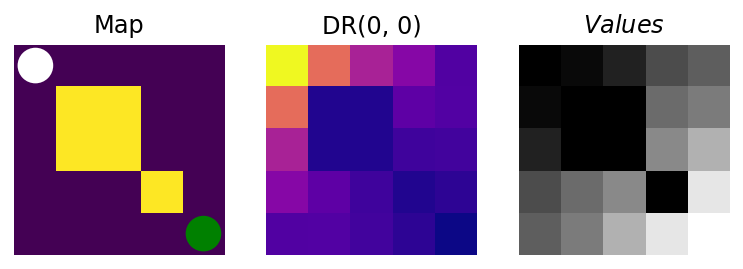

In [21]:
make_plots(agent)

In [22]:
print(f"Start location: {agent.start_loc}, Target location: {agent.target_loc}")
traj_not_blocked = test_agent(agent)

Start location: [0 0], Target location: [4 4]
Starting in state: [0 0]
Took action: 0 and arrived in state: [1 0]
Took action: 0 and arrived in state: [2 0]
Took action: 0 and arrived in state: [3 0]
Took action: 1 and arrived in state: [3 1]
Took action: 1 and arrived in state: [3 2]
Took action: 0 and arrived in state: [4 2]
Took action: 1 and arrived in state: [4 3]
Took action: 1 and arrived in state: [4 4]
Took 8 steps


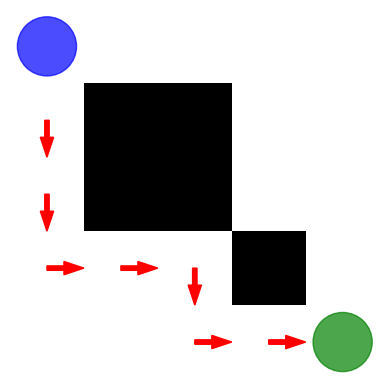

In [23]:
record_trajectory(agent, traj_not_blocked)

## DETOUR

In [32]:
# Get new maze and initialize a new agent
env_blocked = gym.make("tolman-9x9-b")
maze_blocked = env_blocked.unwrapped.maze
new_agent = LinearRL(env_name="tolman-9x9-b")

In [33]:
loc = (4,3)
idx = agent.mapping[loc]

In [34]:
D0 = agent.DR
L0 = np.diag(np.exp(-agent.r)) - agent.T
L = np.diag(np.exp(-agent.r)) - new_agent.T

In [35]:
changes = []

d = L[idx, :] - L0[idx, :]
m0 = D0[:,idx]

# Convert d to a row vector of size (1, m)
d = d.reshape(1, -1)

# Convert m0 to a column vector of size (m, 1)
m0 = m0.reshape(-1, 1)

print(f"d shape: {d.shape}, m0 shape: {m0.shape}")
print(f"numerator shape: {(np.dot(m0,d)).shape}")
print(f"denominator shape: {(np.dot(d, m0)).shape}")
alpha = (np.dot(m0,d)) / (1 + (np.dot(d,m0)))
print(f"alpha shape: {alpha.shape}")
change = np.dot(alpha,D0)
changes.append(change)

D = np.copy(D0)
for change in changes:
    D -= change

d shape: (1, 81), m0 shape: (81, 1)
numerator shape: (81, 81)
denominator shape: (1, 1)
alpha shape: (81, 81)


In [36]:
new_agent.DR = D
new_agent.update_V()

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_97399/2437139880.py:83: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_97399/2437139880.py:83: RuntimeWarning: invalid value encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [37]:
print(new_agent.V.reshape(9,9))

[[ -inf  -inf  -inf -5.38  -inf  -inf  -inf  -inf  -inf]
 [ -inf  -inf  -inf -5.31  -inf  -inf  -inf  -inf  -inf]
 [-3.43 -3.84 -4.32 -5.19 -4.99 -4.8  -4.52 -4.18 -3.89]
 [-3.1   -inf  -inf   nan  -inf  -inf  -inf  -inf -3.56]
 [-2.71  -inf  -inf   nan  -inf  -inf  -inf  -inf -3.26]
 [-2.39  -inf  -inf -1.8   -inf  -inf  -inf  -inf -2.98]
 [-2.03 -1.69 -1.37 -1.   -1.33 -1.66 -2.02 -2.32 -2.65]
 [ -inf  -inf  -inf -0.18  -inf  -inf  -inf  -inf  -inf]
 [ -inf  -inf  -inf  0.    -inf  -inf  -inf  -inf  -inf]]


In [38]:
print("Testing new agent with blocked environment")
print(f"Start location: {new_agent.start_loc}, Target location: {new_agent.target_loc}")
traj_blocked = test_agent(new_agent)

Testing new agent with blocked environment
Start location: [0 3], Target location: [8 3]
Starting in state: [0 3]
Took action: 0 and arrived in state: [1 3]
Took action: 0 and arrived in state: [2 3]
Took action: 3 and arrived in state: [2 2]
Took action: 3 and arrived in state: [2 1]
Took action: 3 and arrived in state: [2 0]
Took action: 0 and arrived in state: [3 0]
Took action: 0 and arrived in state: [4 0]
Took action: 0 and arrived in state: [5 0]
Took action: 0 and arrived in state: [6 0]
Took action: 1 and arrived in state: [6 1]
Took action: 1 and arrived in state: [6 2]
Took action: 1 and arrived in state: [6 3]
Took action: 0 and arrived in state: [7 3]
Took action: 0 and arrived in state: [8 3]
Took 14 steps


/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_97399/2437139880.py:122: RuntimeWarning: invalid value encountered in log
  action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)


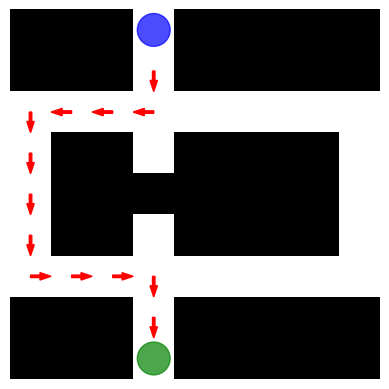

In [39]:
record_trajectory(new_agent, traj_blocked)

## DETOUR DELTA

In [450]:
# Find states whose transition has changed (will show up as -1)
T_diff = new_agent.T - agent.T
J = np.unique(np.where(T_diff < 0)[0])
J = [30,48]

# D0 = agent.DR
L0 = np.diag(np.exp(-agent.r)) - agent.T
D0 = np.linalg.inv(L0)
L = np.diag(np.exp(-agent.r)) - new_agent.T

delta = L[J] - L0[J]

In [451]:
print(J)

[30, 48]


In [452]:
D0J = D0[:, J]

In [453]:
delta_d0 = np.dot(delta, D0)
print(f"shape of delta_d0: {delta_d0.shape}")

delta_d0J = np.dot(delta, D0J)
print(f"shape of delta_d0: {delta_d0J.shape}")

inv = np.linalg.inv(np.eye(len(delta_d0J)) - delta_d0J)
print(f"shape of inv: {inv.shape}")

shape of delta_d0: (2, 81)
shape of delta_d0: (2, 2)
shape of inv: (2, 2)


In [454]:
B = D0J @ inv @ delta_d0
print(f"shape of B: {B.shape}")

shape of B: (81, 81)


In [455]:
D = D0 - B

In [456]:
new_agent.DR = D
new_agent.update_V()

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_90782/681268101.py:81: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [457]:
new_agent.V

array([ -inf,  -inf,  -inf, -3.26,  -inf,  -inf,  -inf,  -inf,  -inf,
        -inf,  -inf,  -inf, -2.26,  -inf,  -inf,  -inf,  -inf,  -inf,
       -4.91, -3.92, -2.29, -0.64, -2.29, -3.95, -5.61, -7.23, -8.22,
       -3.9 ,  -inf,  -inf,  1.7 ,  -inf,  -inf,  -inf,  -inf, -7.21,
       -2.28,  -inf,  -inf,  3.37,  -inf,  -inf,  -inf,  -inf, -5.59,
       -0.62,  -inf,  -inf,  5.03,  -inf,  -inf,  -inf,  -inf, -3.93,
        1.04,  2.7 ,  4.35,  6.01,  4.35,  2.7 ,  1.04, -0.62, -2.28,
        -inf,  -inf,  -inf,  8.33,  -inf,  -inf,  -inf,  -inf,  -inf,
        -inf,  -inf,  -inf, 10.  ,  -inf,  -inf,  -inf,  -inf,  -inf])

## Grid Cells

In [49]:
eigvals, eigvecs = np.linalg.eig(new_agent.DR)
# eigvals, eigvecs = np.linalg.eig(agent.DR)

In [52]:
new_agent.DR.shape

(81, 81)

In [51]:
print(eigvals)

[16.23616125+0.j         11.8917943 +0.j         10.23979788+0.j
  6.0748564 +0.j          5.7106067 +0.j          3.77504111+0.j
  3.29455594+0.j          2.56048956+0.j          2.11518719+0.j
  1.8450178 +0.j          1.51817255+0.j          1.3479308 +0.j
  1.18433767+0.j          1.00729773+0.j          0.99768851+0.0297424j
  0.99768851-0.0297424j   0.9237686 +0.03762579j  0.9237686 -0.03762579j
  0.80971597+0.j          0.7520578 +0.j          0.69655915+0.j
  0.6588947 +0.j          0.62385476+0.j          0.57782592+0.j
  0.51688994+0.j          0.59034762+0.j          0.54433882+0.j
  0.52546969+0.j          0.55072276+0.j          0.52409762+0.j
  1.        +0.j          1.        +0.j          1.        +0.j
  1.        +0.j          1.        +0.j          1.        +0.j
  1.        +0.j          1.        +0.j          1.        +0.j
  1.        +0.j          1.        +0.j          1.        +0.j
  1.        +0.j          1.        +0.j          1.        +0.j
  1.      

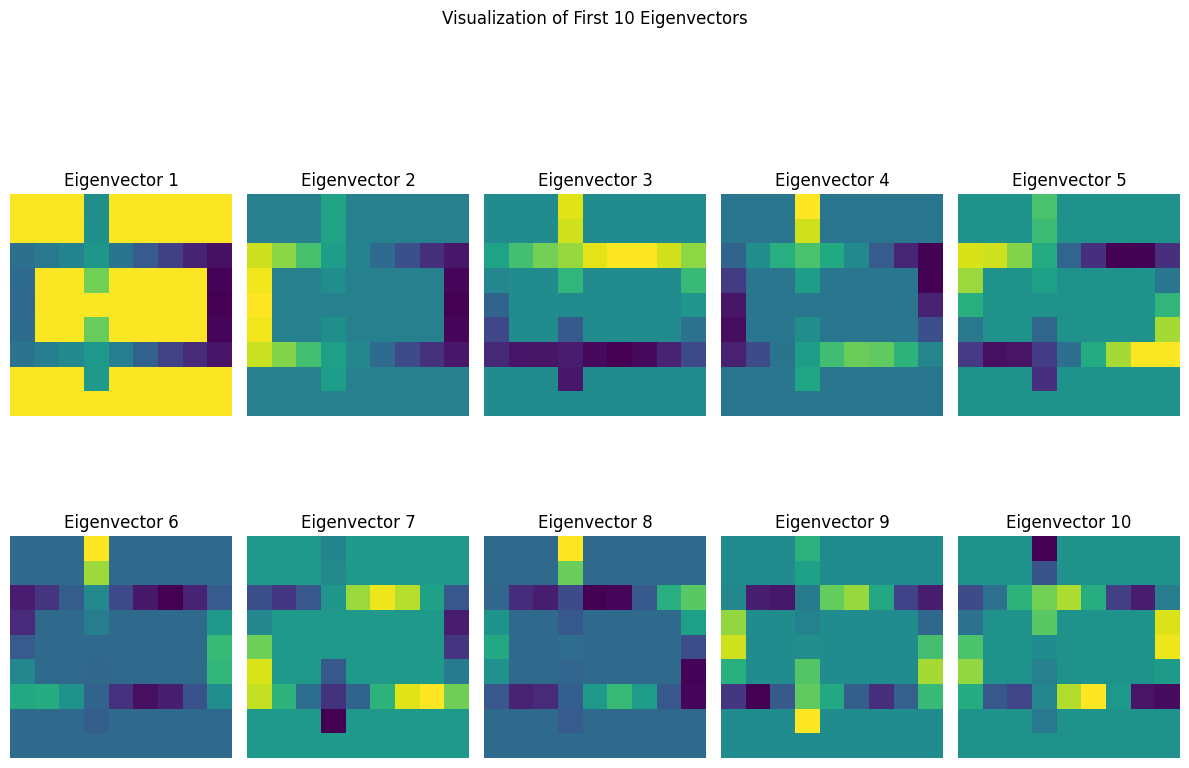

In [53]:
# Select the first 10 eigenvalues and eigenvectors
num_eigenpairs = 10
selected_eigvals = eigvals[:num_eigenpairs]
selected_eigvecs = eigvecs[:, :num_eigenpairs]

# Create a 3x4 subplot grid (adjust the layout accordingly)
fig, axs = plt.subplots(2, 5, figsize=(12, 9))
fig.suptitle('Visualization of First 10 Eigenvectors')

# Loop through the selected eigenvectors
for i in range(num_eigenpairs):
    row, col = divmod(i, 5)
    # Extract the real part, eliminating small imaginary parts
    eigvec_real = np.real_if_close(selected_eigvecs[:, i])
    
    # Plot the real part of eigenvector
    axs[row, col].imshow(eigvec_real.reshape((9, 9)), cmap='viridis')
    axs[row, col].set_title(f'Eigenvector {i + 1}')
    axs[row, col].axis("off")

    # # Reshape eigenvector to 9x9
    # eigvec_reshaped = selected_eigvecs[:, i].reshape((9, 9))
    
    # # Plot eigenvector
    # axs[row, col].imshow(eigvec_reshaped, cmap='viridis_r')
    # axs[row, col].set_title(f'Eigenvector {i + 1}')
    # axs[row, col].axis("off")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()